In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score,classification_report, roc_curve
import os
from sklearn.model_selection import  RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle
import shap

In [1]:
#Não tendo GPU, precisa utilizar o tabPFN alocado na nuvem do PriorLabs
#!pip install tabpfn-client
from tabpfn_client import init, TabPFNClassifier, TabPFNRegressor

## Setup e Importação

In [7]:
# Caminho do arquivo CSV no Google Drive
csv_file = os.getcwd() +"\\dados\\dados_tuberculose_2013_2023_limpo.csv"

df = pd.read_csv(csv_file, encoding='latin1', low_memory=False)

In [8]:
dummy_var = ('CS_SEXO')

## Filtros 

| Nome UF | Código IBGE |
| --- | --- |
|Rondônia|11|
|Acre|12|
|Amazonas|13|
|Roraima|14|
|Pará|15|
|Amapá|16|
|Tocantins|17|
|Maranhão|21|
|Piauí|22|
|Ceará|23|
|Rio Grande do Norte|24|
|Paraíba|25|
|Pernambuco|26|
|Alagoas|27|
|Sergipe|28|
|Bahia|29|
|Minas Gerais|31|
|Espírito Santo|32|
|Rio de Janeiro|33|
|São Paulo|35|
|Paraná|41|
|Santa Catarina|42|
|Rio Grande do Sul|43|
|Mato Grosso do Sul|50|
|Mato Grosso|51|
|Goiás|52|
|Distrito Federal|53|

## Modelagem São Paulo

In [13]:
# Filtrar para o estado de São Paulo (SG_UF == 35)
df_sp = df[df['SG_UF'] == 35].copy()

# Confirmar o tamanho do novo DataFrame
print(f"Quantidade de registros para São Paulo: {df_sp.shape[0]}")


Quantidade de registros para São Paulo: 232809


In [14]:
#Proporção de desfecho
df_sp['ABANDONO'].value_counts()/df_sp.shape[0]

ABANDONO
0    0.853811
1    0.146189
Name: count, dtype: float64

In [15]:
# 1. Criar o DataFrame com as variáveis selecionadas
variaveis_independentes = [ 'IDADE_ANOS',
    'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_OCUPA_N', 'TRATAMENTO',
    'RAIOX_TORA', 'TESTE_TUBE', 'FORMA', 'AGRAVAIDS', 'AGRAVALCOO', 'AGRAVDIABE',
    'AGRAVDOENC', 'AGRAVOUTRA', 'BACILOSC_E', 'BACILOS_E2', 'BACILOSC_O',
    'CULTURA_ES', 'CULTURA_OU', 'HIV', 'HISTOPATOL',
    'RIFAMPICIN', 'ISONIAZIDA', 'ETAMBUTOL', 'ESTREPTOMI', 'PIRAZINAMI',
    'ETIONAMIDA', 'OUTRAS',    'OUTRAS_DES',
    'TRAT_SUPER', 'NU_CONTATO', 'DOENCA_TRA', 'SG_UF_AT', 'ID_MUNIC_A',
    'SG_UF_2', 'BACILOSC_1', 'BACILOSC_2', 'BACILOSC_3', 'BACILOSC_4',
    'BACILOSC_5', 'BACILOSC_6', 'TRATSUP_AT', 'NU_COMU_EX', 'SITUA_9_M',
    'SITUA_12_M', 'TPUNINOT', 'POP_LIBER', 'POP_RUA', 'POP_SAUDE', 'POP_IMIG',
    'BENEF_GOV', 'AGRAVDROGA', 'AGRAVTABAC', 'TEST_MOLEC', 'TEST_SENSI',
    'ANT_RETRO', 'BAC_APOS_6', 'TRANSF'
]

# Novo DataFrame com as variáveis independentes e alvo
df_modelagem = df_sp[['ABANDONO'] + variaveis_independentes].copy()

In [16]:
df_modelagem.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
# Verificar valores ausentes e tratar
df_modelagem = df_modelagem.fillna(-1)  # Preencher valores ausentes com -1 (indicativo de "desconhecido")

In [17]:
#Retirar df_modelagem['OUTRAS_DES'] == CO
df_modelagem = df_modelagem[df_modelagem['OUTRAS_DES'] != 'CO']

In [18]:
print('OUTRAS_DES:',df_modelagem['OUTRAS_DES'].unique())
print('CS_SEXO:',df_modelagem['CS_SEXO'].unique())
print('ETIONAMIDA:',df_modelagem['ETIONAMIDA'].unique())
print('BACILOS_E2:',df_modelagem['BACILOS_E2'].unique())

#Checar o significado dessas classificações

OUTRAS_DES: ['9' '0']
CS_SEXO: ['M' 'F']
ETIONAMIDA: ['2' '0' '1' '9']
BACILOS_E2: ['1' '3' '2' '0' '9']


In [19]:
#Tratamento Dummies
gender_mapping = {"F":1, "M":0}
df_modelagem[dummy_var] = df_modelagem[dummy_var].map(gender_mapping) 

In [20]:
#Convertendo para numerico
convert_to_num = ('OUTRAS_DES', 'BACILOS_E2', 'ETIONAMIDA')

for col in convert_to_num:
    df_modelagem[col] = pd.to_numeric(df_modelagem[col])

In [21]:
# 2. Separar variável dependente (y) e independentes (X)
X = df_modelagem[variaveis_independentes]
y = df_modelagem['ABANDONO']

In [22]:
# 3. Dividir em treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [23]:
#Checar se retiramos o ID do municipio

#Checar a divisão do X
pd.DataFrame({'X_train_mean':X_train.mean(),
              'X_test_mean':X_test.mean(),
              'mean_difference': X_train.mean() - X_test.mean(), 
              'X_train_std':X_train.std(),
              'X_test_std':X_test.std()
              })

,X_train_mean,X_test_mean,mean_difference,X_train_std,X_test_std
IDADE_ANOS,38.634514,38.773672,-0.139158,16.100754,16.200377
CS_SEXO,0.275826,0.275761,0.000065,0.446931,0.446900
CS_GESTANT,6.125174,6.100425,0.024749,2.865510,2.876772
CS_RACA,3.339582,3.336183,0.003400,2.730244,2.726455
CS_ESCOL_N,4.459632,4.441862,0.017770,2.844032,2.851539
ID_OCUPA_N,7.365029,7.369901,-0.004872,3.509505,3.565773
TRATAMENTO,1.314080,1.318987,-0.004907,0.774635,0.787094
RAIOX_TORA,2.002964,2.002778,0.000186,1.368576,1.369075
TESTE_TUBE,5.057313,5.036024,0.021289,4.465150,4.467747
FORMA,1.202178,1.203514,-0.001335,0.477602,0.481306


In [24]:
#Checar  a divisão do desfecho
pd.DataFrame({'y_train_Abondono':y_train.value_counts()/y_train.shape[0],
              'y_test_Abondono':y_test.value_counts()/y_test.shape[0]
              })

,y_train_Abondono,y_test_Abondono
ABANDONO,,
0,0.853815,0.853815
1,0.146185,0.146185


### Random Forest

In [22]:
rf = RandomForestClassifier(random_state=42)

In [ ]:

# defining the possibilities of hyperparameters that will be tested.
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4]
bootstrap = [True, False]

# Crating param grid.
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

# Random Search for tuning.
cv_rf = RandomizedSearchCV(rf, n_iter=50, cv=10, verbose=1, param_distributions=param_grid,n_jobs = -1)

In [ ]:
#Novo espaço de hiperparametrização para o random forest
#Hiperparametrização roda mais rápido

n_estimators = [100, 300, 500]
max_depth = [10, 15, 20]
min_samples_split = [2, 5]
min_samples_leaf = [2, 4]

In [88]:
# Hyperparameter Tuning.
cv_rf.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   verbose=1)

In [89]:
# Best hyperparameters combination.
cv_rf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=325, random_state=42)

In [18]:
# Random Forest with best hyperparameters combination.
rf = RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                            min_samples_split=5, n_estimators=325, 
                            random_state=42)

In [ ]:
model = rf.fit(X_train, y_train)
prob_pos_rf = model.predict_proba(X_test)[:, 1]
y_pred_rf = model.predict(X_test)

print('Random Forest Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_rf)))
#print(classification_report(y_test, y_pred_rf))

#Saving model
pickle.dump(model, open("modelos_hiperparametrizados/rf.pkl", 'wb'))


Random Forest Model
Accuracy: 0.8997
Precision: 0.7598
Recall: 0.4591
AUC: 0.9049


### XGBoost

In [29]:
xgboost = xgb.XGBClassifier()

In [30]:
grid_xgboost = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.05, 0.1]
}

rs_cv_xgboost = RandomizedSearchCV(xgboost,
            grid_xgboost,
            cv=10,
            n_iter=5,
            scoring = 'roc_auc',
            return_train_score = False,
            random_state=42)

In [31]:
# Hyperparameter Tuning.
rs_cv_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5,
                   param_distributions={'eta': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, scoring='roc_auc')

In [32]:
# Best hyperparameters to XGBoost.
best_xgb = rs_cv_xgboost.best_params_

In [34]:
best_xgb

{'n_estimators': 500, 'max_depth': 6, 'eta': 0.05}

In [33]:
# XGBoost with best hyperparameters combination.
xgboost = xgb.XGBClassifier(**best_xgb, random_state=42)

In [35]:
xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
prob_pos_xgboost = xgboost.predict_proba(X_test)[:,1]

print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_xgboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_xgboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_xgboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_xgboost)))

#Saving model
pickle.dump(xgboost, open("modelos_hiperparametrizados/xgboost.pkl", 'wb'))

XGBoost Model
Accuracy: 0.9024
Precision: 0.7263
Recall: 0.5337
AUC: 0.9125


### LightGBM

In [37]:
lgbm = lgb.LGBMClassifier()

In [41]:
rs_params_lgbm = {
        'bagging_fraction': [0.5, 0.8, 1],
        'feature_fraction': (0.5, 0.8, 1),
        #'max_depth': -1, #se limitar o crescimento pelo num_leaves, deixe o max_depth ilimitado (-1). São redundantes.
        'num_leaves': [256, 512],
        'min_data_in_leaf': [90, 120]
        }


rs_cv_lgbm = RandomizedSearchCV(lgbm, param_distributions=rs_params_lgbm, cv = 10, n_iter=50)

In [51]:
#rodando o search para hiperparametrização
#rs_cv_lgbm.fit(X_train, y_train)

# Melhores hiperparametros
best_lgbm = rs_cv_lgbm.best_params_

#treinando o modelo
lgbm = lgb.LGBMClassifier(**best_lgbm, random_state=42)
lgbm.fit(X_train, y_train)

#avaliando a performance
y_pred_lgbm = lgbm.predict(X_test)
prob_pos_lgbm = lgbm.predict_proba(X_test)[:,1]

print('LightGBM Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_lgbm)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_lgbm)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_lgbm)))

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 23823, number of negative: 139142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

### CatBoost

In [52]:
catboost = CatBoostClassifier()

In [53]:
grid_catboost = {"depth": [3, 5, 7, 9, 10],
                "iterations": [250, 500, 1000],
                "learning_rate": [0.01, 0.03, 0.1],
                "l2_leaf_reg": [1, 3, 10],
                "border_count": [32, 50, 100]
               }

rs_cv_catboost = RandomizedSearchCV(catboost, 
                                    param_distributions=grid_catboost,
                                    cv=10,
                                    n_iter=5, 
                                    verbose=1, 
                                    n_jobs = -1,
                                    scoring = 'roc_auc',
                                    return_train_score = False)

In [54]:
#rodando o search para hiperparametrização
rs_cv_catboost.fit(X_train, y_train)

# Melhores hiperparametros
best_catb = rs_cv_catboost.best_params_

#treinando o modelo
catboost = lgb.LGBMClassifier(**best_catb, random_state=42)
catboost.fit(X_train, y_train)

#avaliando a performance
y_pred_catboost = catboost.predict(X_test)
prob_pos_catboost = catboost.predict_proba(X_test)[:,1]

print('CatBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vinic\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\vinic\anaconda3\Lib\site-packages\catboost\core.py", line 24

0:	learn: 0.6594134	total: 193ms	remaining: 3m 13s
1:	learn: 0.6276298	total: 259ms	remaining: 2m 9s
2:	learn: 0.5994191	total: 327ms	remaining: 1m 48s
3:	learn: 0.5730185	total: 391ms	remaining: 1m 37s
4:	learn: 0.5483522	total: 474ms	remaining: 1m 34s
5:	learn: 0.5264326	total: 540ms	remaining: 1m 29s
6:	learn: 0.5064178	total: 602ms	remaining: 1m 25s
7:	learn: 0.4868665	total: 662ms	remaining: 1m 22s
8:	learn: 0.4699082	total: 737ms	remaining: 1m 21s
9:	learn: 0.4551534	total: 808ms	remaining: 1m 19s
10:	learn: 0.4408060	total: 868ms	remaining: 1m 18s
11:	learn: 0.4276079	total: 924ms	remaining: 1m 16s
12:	learn: 0.4156706	total: 991ms	remaining: 1m 15s
13:	learn: 0.4055618	total: 1.06s	remaining: 1m 14s
14:	learn: 0.3951469	total: 1.12s	remaining: 1m 13s
15:	learn: 0.3852556	total: 1.18s	remaining: 1m 12s
16:	learn: 0.3775655	total: 1.26s	remaining: 1m 12s
17:	learn: 0.3708396	total: 1.32s	remaining: 1m 12s
18:	learn: 0.3640307	total: 1.39s	remaining: 1m 11s
19:	learn: 0.3567374	to

### Explicabilidade

In [37]:
#Adjusting SHAP for CatBoost
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer.shap_values(X_test)

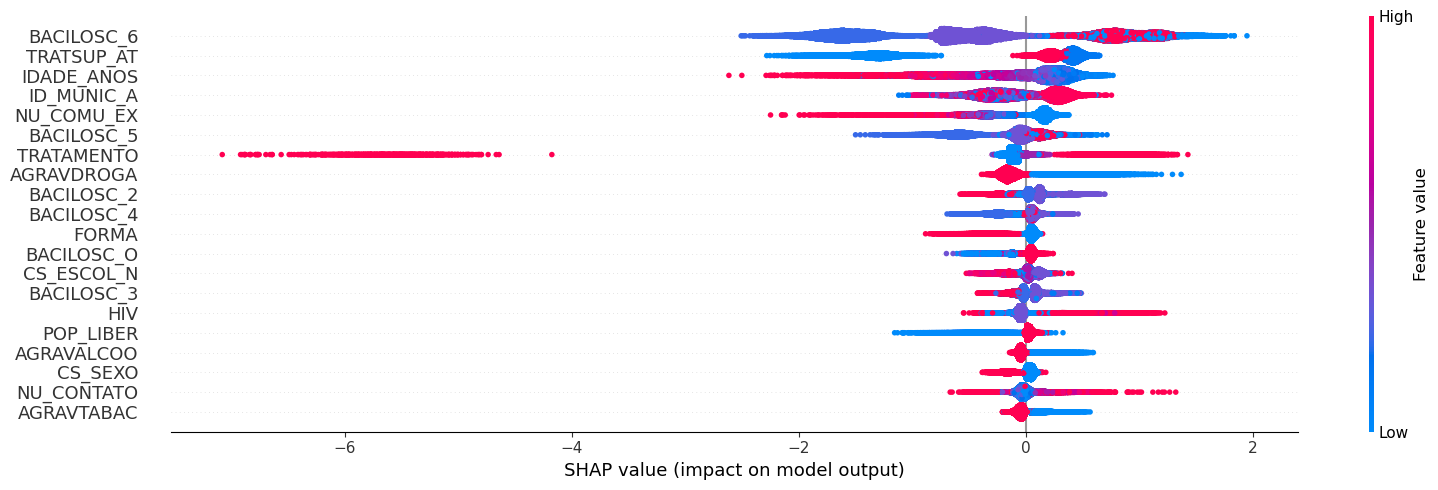

In [38]:
shap.summary_plot(shap_values, X_test, show=False,plot_size=(16, 5))